In [1]:
#необходимые импорты
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger
import pandas as pd
import numpy as np
number_model = None

2023-08-28 11:44:15.720251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 11:44:15.916400: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-28 11:44:16.771713: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/alex/miniconda3/envs/tfGPU/lib/
2023-0

In [2]:
#проверяем - работает ли tensorflow на GPU
#(иногда после тренировки сети tensorflow теряет GPU, тогда надо перезапустить компьютер)
tf.config.list_physical_devices('GPU')

2023-08-28 11:44:19.342485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-28 11:44:19.362508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-28 11:44:19.362595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# ГИПЕРПАРАМЕТРЫ
#количество фильтров в первом сверточном слое
start_filters = 16
#фактор для слоя dropout (сколько будем отключать нейронов в процентах)
drop_conv = 0.2
drop_fc = 0.5
#определяем размер батча и изображения
BATCH_SIZE = 32
IMG_SHAPE = 64
#скорость обучения
learning_rate = 0.0001
#функция активации
act_func = 'elu'
#инициализация весов
initializer = 'he_uniform'
#количество выходов полносвязных слоев
fc_filters = 128
#размер свертки
conv_size = 3

In [23]:
#model_5_2
#для каждого обучения полезно запоминать номер модели в самом начале

number_model = input('введите номер модели: ')

"""
наименование слоев: сначала идет тип слоя, первая цифра - количество выходных фильтров,
                                           вторая цифра - порядковый номер слоя в блоке,
                                           третья цифра - номер блока
название пулинг слоев - просто по порядку.
"""

input_layer = tf.keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 1), name="input")

# first block
out = tf.keras.layers.Conv2D(start_filters, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters) + '_1_1')(input_layer)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters) + '_1_1')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters) + '_1_1')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters) + '_1_1')(out)

out = tf.keras.layers.Conv2D(start_filters, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters) + '_2_1')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters) + '_2_1')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters) + '_2_1')(out)


out = tf.keras.layers.MaxPool2D((2, 2), name = 'pool_1')(out)  
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters) + '_2_1')(out)

#second block
out = tf.keras.layers.Conv2D(start_filters * 2, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters * 2) + '_1_2')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters * 2) + '_1_2')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters * 2) + '_1_2')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters * 2) + '_1_2')(out)

out = tf.keras.layers.Conv2D(start_filters * 2, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters * 2) + '_2_2')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters * 2) + '_2_2')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters * 2) + '_2_2')(out)

#out = tf.keras.layers.MaxPool2D((2, 2), name = 'pool_2')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters * 2) + '_2_2')(out)

#third block
out = tf.keras.layers.Conv2D(start_filters * 4, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters * 4) + '_1_3')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters * 4) + '_1_3')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters * 4) + '_1_3')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters * 4) + '_1_3')(out)

out = tf.keras.layers.Conv2D(start_filters * 4, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters * 4) + '_2_3')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters * 4) + '_2_3')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters * 4) + '_2_3')(out)

out = tf.keras.layers.MaxPool2D((2, 2), name = 'pool_3')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters * 4) + '_2_3')(out)

#forth block
out = tf.keras.layers.Conv2D(start_filters * 8, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters * 8) + '_1_4')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters * 8) + '_1_4')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters * 8) + '_1_4')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters * 8) + '_1_4')(out)

out = tf.keras.layers.Conv2D(start_filters * 8, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters * 8) + '_2_4')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters * 8) + '_2_4')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters * 8) + '_2_4')(out)

#out = tf.keras.layers.MaxPool2D((2, 2), name = 'pool_4')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters * 8) + '_2_4')(out)

#fifth block
out = tf.keras.layers.Conv2D(start_filters * 16, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters * 16) + '_1_5')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters * 16) + '_1_5')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters * 16) + '_1_5')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters * 16) + '_1_5')(out)

out = tf.keras.layers.Conv2D(start_filters * 16, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters * 16) + '_2_5')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters * 16) + '_2_5')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters * 16) + '_2_5')(out)

out = tf.keras.layers.MaxPool2D((2, 2), name = 'pool_5')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters * 16) + '_2_5')(out)


#sixth block
out = tf.keras.layers.Conv2D(start_filters * 32, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters * 32) + '_1_5')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters * 32) + '_1_5')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters * 32) + '_1_5')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters * 32) + '_1_5')(out)

out = tf.keras.layers.Conv2D(start_filters * 32, (conv_size, conv_size), padding='same',
                             kernel_initializer = initializer,
                             name = 'conv' + str(start_filters * 32) + '_2_5')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation' + str(start_filters * 32) + '_2_5')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm' + str(start_filters * 32) + '_2_5')(out)

#out = tf.keras.layers.MaxPool2D((2, 2), name = 'pool_6')(out)
out = tf.keras.layers.Dropout(drop_conv, name = 'dropout' + str(start_filters * 32) + '_2_5')(out)



#final block
out = tf.keras.layers.GlobalAveragePooling2D(name = 'GAP')(out)


out = tf.keras.layers.Dense(fc_filters, kernel_initializer = initializer, name = 'dense_1')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation_dense_1')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm_dense_1')(out)
out = tf.keras.layers.Dropout(drop_fc, name = 'dropout_dense_1')(out)

out = tf.keras.layers.Dense(fc_filters, kernel_initializer = initializer, name = 'dense_2')(out)
out = tf.keras.layers.Activation(act_func, name = 'activation_dense_2')(out)
out = tf.keras.layers.BatchNormalization(name = 'batchnorm_dense_2')(out)
out = tf.keras.layers.Dropout(drop_fc, name = 'dropout_dense_2')(out)

out = tf.keras.layers.Dense(9, activation = 'softmax', name = 'output')(out)

model = tf.keras.Model(inputs=input_layer, outputs=out)

введите номер модели: 2


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 64, 64, 1)]       0         
                                                                 
 conv32_1_1 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 activation32_1_1 (Activatio  (None, 64, 64, 32)       0         
 n)                                                              
                                                                 
 batchnorm32_1_1 (BatchNorma  (None, 64, 64, 32)       128       
 lization)                                                       
                                                                 
 dropout32_1_1 (Dropout)     (None, 64, 64, 32)        0         
                                                                 
 conv32_2_1 (Conv2D)         (None, 64, 64, 32)        9248

                                                                 
 dropout_dense_1 (Dropout)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 activation_dense_2 (Activat  (None, 256)              0         
 ion)                                                            
                                                                 
 batchnorm_dense_2 (BatchNor  (None, 256)              1024      
 malization)                                                     
                                                                 
 dropout_dense_2 (Dropout)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 activatio

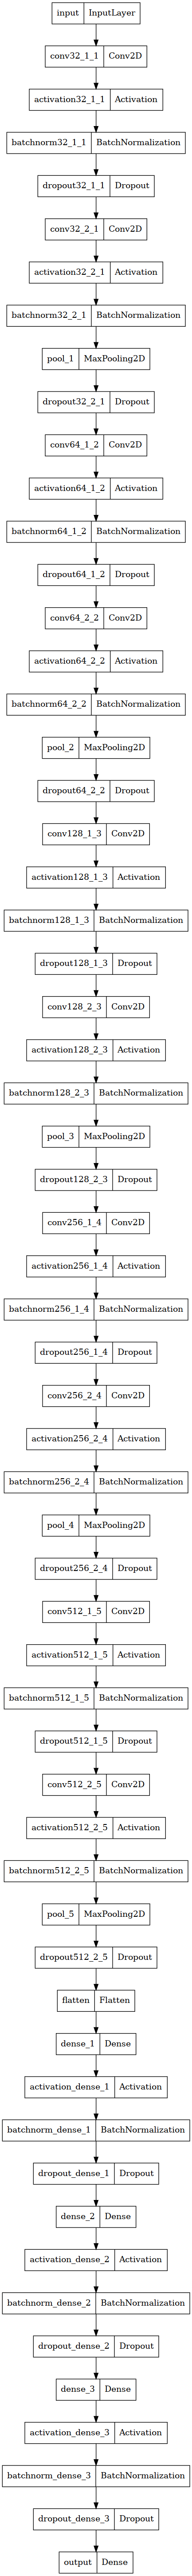

In [7]:
model.summary()
tf.keras.utils.plot_model(model)

In [24]:
# сохраним текущую модель в файл

with open('model_5_2_summary.txt', 'w') as f:

    model.summary(print_fn=lambda x: f.write(x + '\n'))

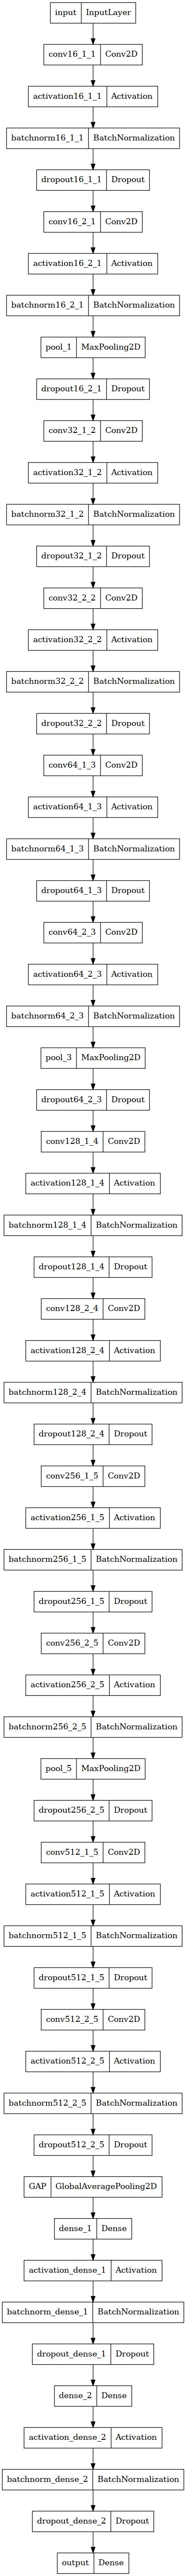

In [25]:
#также сохраним графическое представление текущей модели в файл

tf.keras.utils.plot_model(model, to_file='model_5_2.jpg')

In [26]:
#функция для проверки - сколько нам надо примерно памяти процессора для тренировки этой модели

def keras_model_memory_usage_in_bytes(model, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    
    total_memory = round(total_memory / 1000000, 1)
    total_memory = str(total_memory) + 'MB'
    return total_memory



In [27]:
#проверяем требуемое количество памяти процессора
print(keras_model_memory_usage_in_bytes(model, 32))

294.9MB


In [10]:
#функция для поиска оптимального размера батча

def FindBatchSize(model):
    """#model: model architecture, that is yet to be trained"""
    import os, sys, psutil, gc, tensorflow, keras
    import numpy as np
    from keras import backend as K
    BatchFound= 16

    try:
        total_params= int(model.count_params());    GCPU= "CPU"
        #find whether gpu is available
        try:
            if K.tensorflow_backend._get_available_gpus()== []:
                GCPU= "CPU";    #CPU and Cuda9GPU
            else:
                GCPU= "GPU"
        except:
            from tensorflow.python.client import device_lib;    #Cuda8GPU
            def get_available_gpus():
                local_device_protos= device_lib.list_local_devices()
                return [x.name for x in local_device_protos if x.device_type == 'GPU']
            if "gpu" not in str(get_available_gpus()).lower():
                GCPU= "CPU"
            else:
                GCPU= "GPU"

        #decide batch size on the basis of GPU availability and model complexity
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <1000000):
            BatchFound= 64    
        if (os.cpu_count() <16) and (total_params <500000):
            BatchFound= 64  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <2000000) and (total_params >=1000000):
            BatchFound= 32      
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=2000000) and (total_params <10000000):
            BatchFound= 16  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=10000000):
            BatchFound= 8       
        if (os.cpu_count() <16) and (total_params >5000000):
            BatchFound= 8    
        if total_params >100000000:
            BatchFound= 1

    except:
        pass
    try:

        #find percentage of memory used
        memoryused= psutil.virtual_memory()
        memoryused= float(str(memoryused).replace(" ", "").split("percent=")[1].split(",")[0])
        if memoryused >75.0:
            BatchFound= 8
        if memoryused >85.0:
            BatchFound= 4
        if memoryused >90.0:
            BatchFound= 2
        if total_params >100000000:
            BatchFound= 1
        print("Batch Size:  "+ str(BatchFound));    gc.collect()
    except:
        pass

    memoryused= [];    total_params= [];    GCPU= "";
    del memoryused, total_params, GCPU;    gc.collect()
    return BatchFound

In [11]:
print(FindBatchSize(model))

Batch Size:  16
16


2023-08-25 21:30:13.787257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 21:30:13.787421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 21:30:13.787563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 21:30:13.787692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-25 21:30:13.787767: I tensorflow/compiler/xla/stream_executo

In [4]:
#CALLBACKS

#определим путь где у нас будет сохраняться модель
name_model = input('введите название модели: ')

#проверяем ввели ли номер модели (может не быть в случае загрузки уже тренированной модели)
if number_model is None:
    number_model = input('введите номер модели: ') 

filepath = './' + name_model + '/' + str(number_model)

#ранняя остановка, когда sparse_categorical_accuracy уже не изменяется
my_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'sparse_categorical_accuracy',
                                              min_delta = 0,
                                               patience = 0,
                                              mode = 'auto')

#создаем checkpoint
my_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                   monitor = 'sparse_categorical_accuracy', 
                                                   verbose = True, 
                                                   save_best_only = True, 
                                                   mode = 'max')

#ReduceLROnPlateau используем только если у нас не будет улучшения в течении 5 эпох
my_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'sparse_categorical_accuracy', factor = 0.2, patience = 5)


#запись истории обучения в csv файл
csv_logger = CSVLogger(name_model + '_' + str(number_model) + '.csv')

#создаем список callback'ов для передачи его в метод fit
callbacks_list = [PlotLossesCallback(), my_checkpoint, csv_logger]

введите название модели: model_5
введите номер модели: 2


In [5]:
#определяем генераторы данных, в качестве препроцессинга только rescale
train_image_generator      = ImageDataGenerator(rescale=1./255,
                                               rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)  
validation_image_generator = ImageDataGenerator(rescale=1./255,
                                               rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

train_dir = '/home/alex/Documents/SKILLBOX/ИТОГОВЫЙ_ПРОЕКТ/clean_train/train'
validation_dir = '/home/alex/Documents/SKILLBOX/ИТОГОВЫЙ_ПРОЕКТ/clean_train/validation'

In [6]:
#создаем генераторы данных
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           color_mode = 'grayscale',
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='sparse')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              color_mode = 'grayscale',
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='sparse')

Found 49195 images belonging to 9 classes.
Found 12446 images belonging to 9 classes.


In [31]:
#компилируем нашу модель
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [7]:
#грузим сохраненую модель

#проверяем ввели ли номер модели
if number_model is None:
    number_model = input('введите номер модели: ')
    
model = load_model('./model_5/' + number_model)

2023-08-28 11:44:45.364488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 11:44:45.365270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-28 11:44:45.365528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-28 11:44:45.365640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

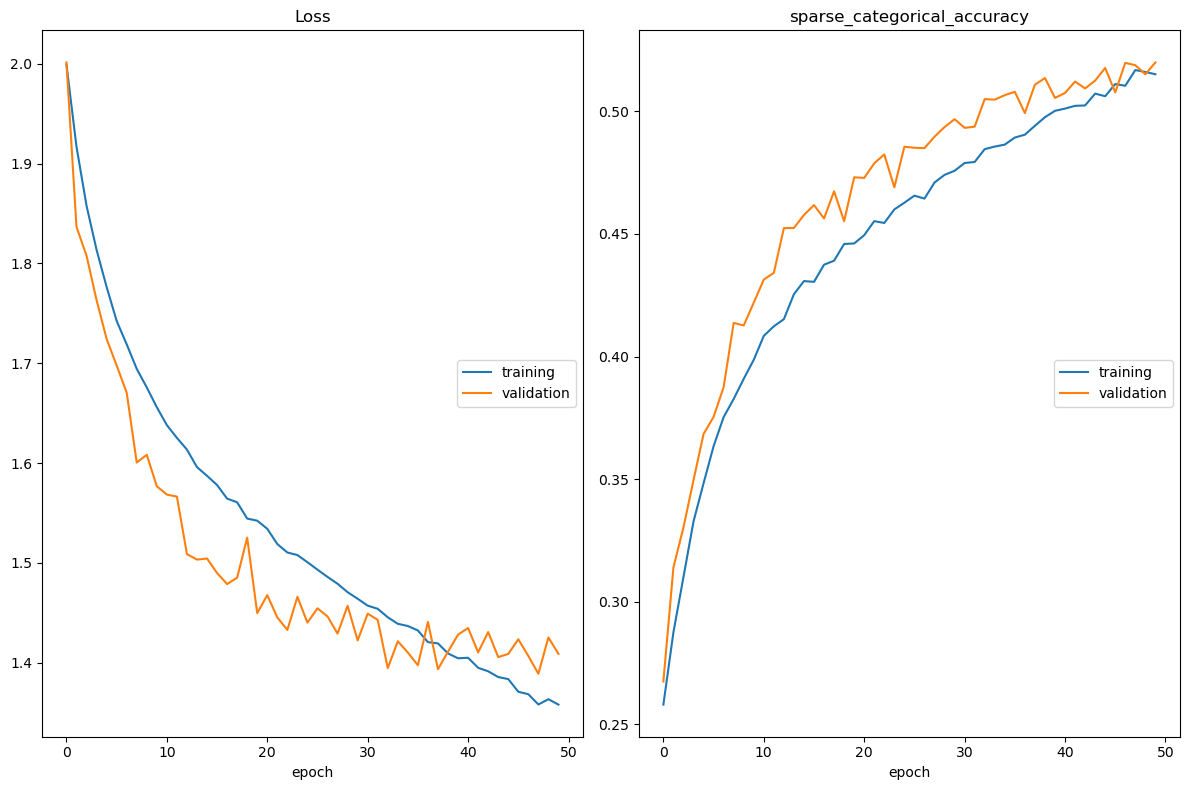

Loss
	training         	 (min:    1.358, max:    1.999, cur:    1.358)
	validation       	 (min:    1.389, max:    2.001, cur:    1.409)
sparse_categorical_accuracy
	training         	 (min:    0.258, max:    0.517, cur:    0.515)
	validation       	 (min:    0.267, max:    0.520, cur:    0.520)

Epoch 50: sparse_categorical_accuracy did not improve from 0.51682
1538/1538 [==============================] - 176s 114ms/step - loss: 1.3580 - sparse_categorical_accuracy: 0.5151 - val_loss: 1.4088 - val_sparse_categorical_accuracy: 0.5199
Epoch 51/80
 987/1538 [==================>...........] - ETA: 50s - loss: 1.3484 - sparse_categorical_accuracy: 0.5212

KeyboardInterrupt: 

In [8]:
# количество эпох
EPOCHS = 80

#обучаем нашу модель
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks = callbacks_list)

In [8]:
#определяем генератор для тестового датасета
test_image_generator = ImageDataGenerator(rescale = 1./255)

#путь к папке
test_dir = '/home/alex/Documents/SKILLBOX/ИТОГОВЫЙ_ПРОЕКТ/test'

In [9]:
#определяем генератор для тестового датасета

test_data_gen =  test_image_generator.flow_from_directory(batch_size = 1,
                                                         directory = test_dir,
                                                         color_mode = 'grayscale',
                                                         shuffle = False,
                                                         class_mode = None,
                                                         target_size=(IMG_SHAPE,IMG_SHAPE),
                                                         seed = 42)

Found 5000 images belonging to 1 classes.


In [10]:
STEP_SIZE_TEST = test_data_gen.n//test_data_gen.batch_size
test_data_gen.reset()
pred = model.predict_generator(test_data_gen, verbose = 1)

/tmp/ipykernel_3229/1030421647.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_data_gen, verbose = 1)
2023-08-28 11:45:06.695631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


  39/5000 [..............................] - ETA: 20s  

2023-08-28 11:45:08.465231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5000/5000 [==============================] - 25s 5ms/step


In [12]:
predicted_class_indices = np.argmax(pred, axis = 1)
labels = (train_data_gen.class_indices)
labels = dict((v,k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [13]:
predictions

['sad',
 'neutral',
 'anger',
 'fear',
 'surprise',
 'surprise',
 'contempt',
 'sad',
 'surprise',
 'sad',
 'sad',
 'surprise',
 'neutral',
 'neutral',
 'uncertain',
 'fear',
 'uncertain',
 'uncertain',
 'fear',
 'happy',
 'happy',
 'uncertain',
 'happy',
 'sad',
 'fear',
 'happy',
 'disgust',
 'anger',
 'fear',
 'neutral',
 'fear',
 'disgust',
 'anger',
 'neutral',
 'disgust',
 'uncertain',
 'surprise',
 'surprise',
 'anger',
 'neutral',
 'sad',
 'surprise',
 'uncertain',
 'neutral',
 'fear',
 'fear',
 'neutral',
 'fear',
 'anger',
 'happy',
 'anger',
 'fear',
 'anger',
 'happy',
 'anger',
 'anger',
 'anger',
 'happy',
 'anger',
 'happy',
 'surprise',
 'neutral',
 'uncertain',
 'neutral',
 'neutral',
 'neutral',
 'sad',
 'fear',
 'neutral',
 'surprise',
 'neutral',
 'anger',
 'happy',
 'disgust',
 'disgust',
 'anger',
 'contempt',
 'sad',
 'uncertain',
 'sad',
 'disgust',
 'neutral',
 'sad',
 'surprise',
 'sad',
 'uncertain',
 'uncertain',
 'sad',
 'contempt',
 'happy',
 'happy',
 'un

In [14]:
label_map = pd.DataFrame({'prediction' : predictions,
                         'class' : predicted_class_indices})

In [15]:
print(label_map.drop_duplicates())

   prediction  class
0         sad      6
1     neutral      5
2       anger      0
3        fear      3
4    surprise      7
6    contempt      1
14  uncertain      8
19      happy      4
26    disgust      2


In [16]:
#сохраняем результат в csv файл

filenames = test_data_gen.filenames

results = pd.DataFrame({'image_path' : filenames,
                     'emotion' : predictions})
results.to_csv('results_model' + number_model, index = False)

In [12]:
test_data_gen.filenames

['test_kaggle/0.jpg',
 'test_kaggle/1.jpg',
 'test_kaggle/10.jpg',
 'test_kaggle/100.jpg',
 'test_kaggle/1000.jpg',
 'test_kaggle/1001.jpg',
 'test_kaggle/1002.jpg',
 'test_kaggle/1003.jpg',
 'test_kaggle/1004.jpg',
 'test_kaggle/1005.jpg',
 'test_kaggle/1006.jpg',
 'test_kaggle/1007.jpg',
 'test_kaggle/1008.jpg',
 'test_kaggle/1009.jpg',
 'test_kaggle/101.jpg',
 'test_kaggle/1010.jpg',
 'test_kaggle/1011.jpg',
 'test_kaggle/1012.jpg',
 'test_kaggle/1013.jpg',
 'test_kaggle/1014.jpg',
 'test_kaggle/1015.jpg',
 'test_kaggle/1016.jpg',
 'test_kaggle/1017.jpg',
 'test_kaggle/1018.jpg',
 'test_kaggle/1019.jpg',
 'test_kaggle/102.jpg',
 'test_kaggle/1020.jpg',
 'test_kaggle/1021.jpg',
 'test_kaggle/1022.jpg',
 'test_kaggle/1023.jpg',
 'test_kaggle/1024.jpg',
 'test_kaggle/1025.jpg',
 'test_kaggle/1026.jpg',
 'test_kaggle/1027.jpg',
 'test_kaggle/1028.jpg',
 'test_kaggle/1029.jpg',
 'test_kaggle/103.jpg',
 'test_kaggle/1030.jpg',
 'test_kaggle/1031.jpg',
 'test_kaggle/1032.jpg',
 'test_kaggl